# Model Building

### Importiere Bibliotheken

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns

# region sklearn models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text, export_graphviz
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
#endregion

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt


from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV, cross_val_score

### Datensatz einlesen
Da Pandas die Datentypen der Merkmale nicht optimal erkennt, werden im Folgenden die konkreten Datentypen definiert. \
Diese können aus der Beschreibung des Datensatztes abgeleitet werden.

In [8]:
dtypes = {
    'Air temperature [K]': 'float32',
    'Process temperature [K]': 'float32',
    'Rotational speed [rpm]': 'float32',
    'Torque [Nm]': 'float32',
    'Tool wear [min]': 'float32',
    'Type_H': 'bool',
    'Type_L': 'bool',
    'Type_M': 'bool',
    'label': 'category'
}

df_train_resampled = pd.read_csv('./dataset_train_resampled.csv', dtype=dtypes)
df_test = pd.read_csv('./dataset_test.csv', dtype=dtypes)

### Definiere die Input- und Output- Merkmale

In [9]:
input_columns = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Type_H', 'Type_L', 'Type_M']
output_column = ['label']

X_train = df_train_resampled[input_columns]
X_test = df_test[input_columns]
y_train = df_train_resampled[output_column].to_numpy().ravel()
y_test = df_test[output_column].to_numpy().ravel()

### Extrahiere Ziel-Klassen

In [10]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
unique_classes_str = label_encoder.classes_
unique_classes_int = list(range(len(unique_classes_str)))

### Trainiere die Modelle 

In [11]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Support Vector Machine': SVC(probability=True, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

In [12]:
results_df_test = pd.DataFrame(columns=['Name', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Parameters', 'Class']).reset_index(drop=True)

In [13]:
# ca. 3 min
for i, (model_name, model) in enumerate(models.items(), start=1):
    print(f'Model {i} of {len(models)}: {model_name}')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    results_row = {
        'Name': model_name, 
        'Accuracy' : accuracy_score(y_test, y_pred),
        'Precision' : precision_score(y_test, y_pred, average='weighted', zero_division=1),
        'Recall' : recall_score(y_test, y_pred, average='weighted'),
        'F1 Score' : f1_score(y_test, y_pred, average='weighted'),
        'Parameters' : model.get_params(),
        'Class' : model.__class__
    }

    results_df_test.loc[len(results_df_test)] = results_row

results_df_test

Model 1 of 5: Logistic Regression
Model 2 of 5: Random Forest
Model 3 of 5: Decision Tree
Model 4 of 5: Support Vector Machine
Model 5 of 5: K-Nearest Neighbors


,Name,Accuracy,Precision,Recall,F1 Score,Parameters,Class
0,Logistic Regression,0.7915,0.973379,0.7915,0.866411,"{'C': 1.0, 'class_weight': None, 'dual': False...",<class 'sklearn.linear_model._logistic.Logisti...
1,Random Forest,0.9630,0.971966,0.9630,0.967276,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",<class 'sklearn.ensemble._forest.RandomForestC...
2,Decision Tree,0.9470,0.974520,0.9470,0.960161,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",<class 'sklearn.tree._classes.DecisionTreeClas...
3,Support Vector Machine,0.8535,0.971734,0.8535,0.905161,"{'C': 1.0, 'break_ties': False, 'cache_size': ...",<class 'sklearn.svm._classes.SVC'>
4,K-Nearest Neighbors,0.9105,0.963806,0.9105,0.934648,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",<class 'sklearn.neighbors._classification.KNei...


### Wichtigste Trennung Entscheidungsbaum un Wichtigste Features Random Forest

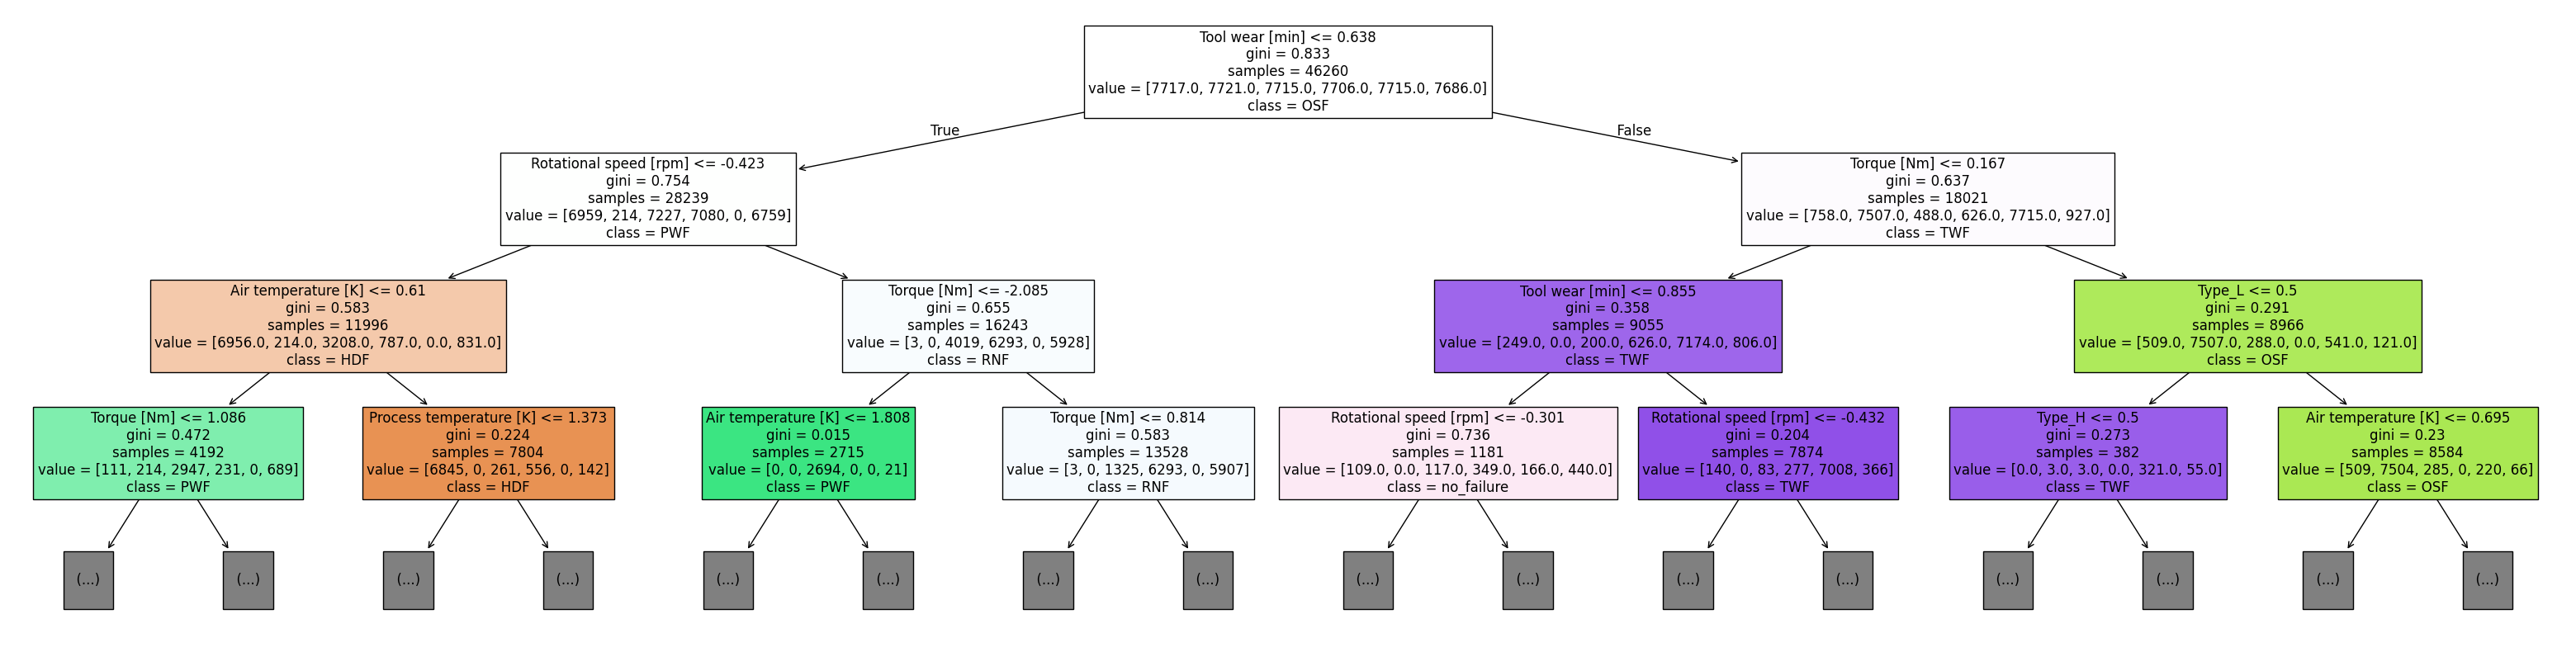

In [14]:
plt.figure(figsize=(40, 10))
_ = plot_tree(
    models['Decision Tree'],
    max_depth=3,
    feature_names=X_test.columns,
    class_names=unique_classes_str,
    fontsize=12,
    filled=True
)

In [15]:
feature_importances = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': models['Random Forest'].feature_importances_
}).sort_values(by='Importance', ascending=False)

fig = px.bar(
    feature_importances, x='Feature', y='Importance',
    title='Feature-Import des RandomForest',
    labels={'Importance': 'Relevanz', 'Feature': 'Merkmal'},
    text_auto=True
)

fig.show()

<font color='lightgreen'>Das RandomForest-Model besitzt den besten F1-Score</font>

### Hyperparameter-Tuning des RandomForest

In [16]:
#ca. 12 min.
parameter_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

grid_search = GridSearchCV(
    RandomForestClassifier(),
    parameter_grid,
    cv=5,
    scoring="f1_weighted",
    n_jobs=-1,
)

grid_search.fit(X_train, y_train)

rf_best = grid_search.best_estimator_

y_pred = rf_best.predict(X_test)

results_row = {
    'Name': 'Random Forest mit Hyperparameter-Tuning', 
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred, average='weighted', zero_division=1),
    'Recall' : recall_score(y_test, y_pred, average='weighted'),
    'F1 Score': f1_score(y_test, y_pred, average='weighted'),
    'Parameters': rf_best.get_params(),
    'Class' : rf_best.__class__
}
results_df_test.loc[len(results_df_test)] = results_row
models['Random Forest mit Hyperparameter-Tuning'] = rf_best

results_df_test

,Name,Accuracy,Precision,Recall,F1 Score,Parameters,Class
0,Logistic Regression,0.7915,0.973379,0.7915,0.866411,"{'C': 1.0, 'class_weight': None, 'dual': False...",<class 'sklearn.linear_model._logistic.Logisti...
1,Random Forest,0.9630,0.971966,0.9630,0.967276,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",<class 'sklearn.ensemble._forest.RandomForestC...
2,Decision Tree,0.9470,0.974520,0.9470,0.960161,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",<class 'sklearn.tree._classes.DecisionTreeClas...
3,Support Vector Machine,0.8535,0.971734,0.8535,0.905161,"{'C': 1.0, 'break_ties': False, 'cache_size': ...",<class 'sklearn.svm._classes.SVC'>
4,K-Nearest Neighbors,0.9105,0.963806,0.9105,0.934648,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",<class 'sklearn.neighbors._classification.KNei...
5,Random Forest mit Hyperparameter-Tuning,0.9630,0.973931,0.9630,0.968094,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",<class 'sklearn.ensemble._forest.RandomForestC...


In [17]:
y_test_bin = label_binarize(y_test, classes=unique_classes_str)
n_classes = y_test_bin.shape[1]

y_prob = model.predict_proba(X_test)

fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    if np.any(y_test_bin[:, i]):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])


fig = go.Figure()

for i in range(n_classes):
    if i in roc_auc:
        fig.add_trace(go.Scatter(
            x=fpr[i], 
            y=tpr[i], 
            mode='lines', 
            name=f'{unique_classes_str[i]} (AUC = {roc_auc[i]:.2f})'
        ))

fig.add_trace(go.Scatter(
    x=[0, 1], 
    y=[0, 1], 
    mode='lines', 
    line=dict(dash='dash'), 
    name='Random Guessing'
))

fig.update_layout(
    title="Receiver Operating Characteristic (ROC) Curve",
    xaxis_title="False Positive Rate",
    yaxis_title="True Positive Rate",
    xaxis=dict(scaleanchor="y", constrain="domain"),
    yaxis=dict(scaleanchor="x", constrain="domain"),
)

fig.show()

### K-Nearest Neighbors mit optimalem K

In [ ]:
#ca. 2 min
k_values = range(1, 31)
cv_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=5)
    cv_scores.append(scores.mean())

optimal_k = k_values[np.argmax(cv_scores)]

knn_best = KNeighborsClassifier(n_neighbors=optimal_k)
knn_best.fit(X_train, y_train)

y_pred = knn_best.predict(X_test)

results_row = {
    'Name': 'K-Nearest Neighbors mit optimalem K', 
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred, average='weighted', zero_division=1),
    'Recall' : recall_score(y_test, y_pred, average='weighted'),
    'F1 Score': f1_score(y_test, y_pred, average='weighted'),
    'Parameters': knn_best.get_params(),
    'Class' : knn_best.__class__
}
results_df_test.loc[len(results_df_test)] = results_row
models['K-Nearest Neighbors mit optimalem K'] = knn_best

results_df_test

TypeError: KNeighborsClassifier.__init__() got an unexpected keyword argument 'random_state'

### Geprunter Tree

In [ ]:
# ca. 2 min
dt = DecisionTreeClassifier(random_state=42)
path = dt.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas[:-1]

f1_scores = []

for alpha in ccp_alphas:
    dt = DecisionTreeClassifier(random_state=42, ccp_alpha=alpha)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    f1_scores.append(f1_score(y_test, y_pred, average='weighted'))
    
optimal_alpha = ccp_alphas[np.argmax(f1_scores)]

dt_best = DecisionTreeClassifier(ccp_alpha=optimal_alpha, random_state=42)
dt_best.fit(X_train, y_train)
y_pred = dt_best.predict(X_test)

results_row = {
    'Name': 'Decision Tree mit Pruning', 
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred, average='weighted', zero_division=1),
    'Recall' : recall_score(y_test, y_pred, average='weighted'),
    'F1 Score': f1_score(y_test, y_pred, average='weighted'),
    'Flexibility Parameter': dt_best.get_params(),
    'Class' : dt_best.__class__
}
results_df_test.loc[len(results_df_test)] = results_row
models['Decision Tree mit Pruning'] = dt_best

results_df_test

,Name,Accuracy,Precision,Recall,F1 Score,Parameters,Class
0,Logistic Regression,0.7915,0.973379,0.7915,0.866411,"{'C': 1.0, 'class_weight': None, 'dual': False...",<class 'sklearn.linear_model._logistic.Logisti...
1,Random Forest,0.9625,0.974088,0.9625,0.967943,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",<class 'sklearn.ensemble._forest.RandomForestC...
2,Decision Tree,0.9475,0.974960,0.9475,0.960759,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",<class 'sklearn.tree._classes.DecisionTreeClas...
3,Support Vector Machine,0.8535,0.971734,0.8535,0.905161,"{'C': 1.0, 'break_ties': False, 'cache_size': ...",<class 'sklearn.svm._classes.SVC'>
4,K-Nearest Neighbors,0.9105,0.963806,0.9105,0.934648,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",<class 'sklearn.neighbors._classification.KNei...
5,Random Forest mit Hyperparameter-Tuning,0.9635,0.973413,0.9635,0.968192,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",<class 'sklearn.ensemble._forest.RandomForestC...
6,K-Nearest Neighbors mit optimalem K,0.9385,0.960073,0.9385,0.948981,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",<class 'sklearn.neighbors._classification.KNei...
7,Decision Tree mit Pruning,0.9495,0.975228,0.9495,0.961795,NaN,<class 'sklearn.tree._classes.DecisionTreeClas...


### Trainingsmetriken

In [ ]:
results_df_train = pd.DataFrame(columns=['Name', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Parameters', 'Class']).reset_index(drop=True)

In [ ]:
# ca. 5 min
for i, (model_name, model) in enumerate(models.items(), start=1):
    print(f'Model {i} of {len(models)}: {model_name}')

    y_train_pred = model.predict(X_train)
    
    results_row = {
        'Name': model_name, 
        'Accuracy': accuracy_score(y_train, y_train_pred),
        'Precision': precision_score(y_train, y_train_pred, average='weighted', zero_division=1),
        'Recall' : recall_score(y_train, y_train_pred, average='weighted'),
        'F1 Score': f1_score(y_train, y_train_pred, average='weighted'),
        'Parameters': model.get_params(),
        'Class' : model.__class__
    }

    results_df_train.loc[len(results_df_train)] = results_row

results_df_test

Model 1 of 8: Logistic Regression
Model 2 of 8: Random Forest
Model 3 of 8: Decision Tree
Model 4 of 8: Support Vector Machine
Model 5 of 8: K-Nearest Neighbors
Model 6 of 8: Random Forest mit Hyperparameter-Tuning
Model 7 of 8: K-Nearest Neighbors mit optimalem K
Model 8 of 8: Decision Tree mit Pruning


,Name,Accuracy,Precision,Recall,F1 Score,Parameters,Class
0,Logistic Regression,0.7915,0.973379,0.7915,0.866411,"{'C': 1.0, 'class_weight': None, 'dual': False...",<class 'sklearn.linear_model._logistic.Logisti...
1,Random Forest,0.9625,0.974088,0.9625,0.967943,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",<class 'sklearn.ensemble._forest.RandomForestC...
2,Decision Tree,0.9475,0.974960,0.9475,0.960759,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",<class 'sklearn.tree._classes.DecisionTreeClas...
3,Support Vector Machine,0.8535,0.971734,0.8535,0.905161,"{'C': 1.0, 'break_ties': False, 'cache_size': ...",<class 'sklearn.svm._classes.SVC'>
4,K-Nearest Neighbors,0.9105,0.963806,0.9105,0.934648,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",<class 'sklearn.neighbors._classification.KNei...
5,Random Forest mit Hyperparameter-Tuning,0.9635,0.973413,0.9635,0.968192,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",<class 'sklearn.ensemble._forest.RandomForestC...
6,K-Nearest Neighbors mit optimalem K,0.9385,0.960073,0.9385,0.948981,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",<class 'sklearn.neighbors._classification.KNei...
7,Decision Tree mit Pruning,0.9495,0.975228,0.9495,0.961795,NaN,<class 'sklearn.tree._classes.DecisionTreeClas...


### Scatterplot vergleich über Trainings und Testmetriken

In [ ]:
results_df_test['Dataset'] = 'Test'
results_df_train['Dataset'] = 'Train'

results_df = pd.concat([results_df_test, results_df_train]).reset_index(drop=True)

results_df['Class'] = results_df['Class'].astype(str)

results_df

,Name,Accuracy,Precision,Recall,F1 Score,Parameters,Class,Dataset
0,Logistic Regression,0.791500,0.973379,0.791500,0.866411,"{'C': 1.0, 'class_weight': None, 'dual': False...",<class 'sklearn.linear_model._logistic.Logisti...,Test
1,Random Forest,0.962500,0.974088,0.962500,0.967943,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",<class 'sklearn.ensemble._forest.RandomForestC...,Test
2,Decision Tree,0.947500,0.974960,0.947500,0.960759,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",<class 'sklearn.tree._classes.DecisionTreeClas...,Test
3,Support Vector Machine,0.853500,0.971734,0.853500,0.905161,"{'C': 1.0, 'break_ties': False, 'cache_size': ...",<class 'sklearn.svm._classes.SVC'>,Test
4,K-Nearest Neighbors,0.910500,0.963806,0.910500,0.934648,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",<class 'sklearn.neighbors._classification.KNei...,Test
5,Random Forest mit Hyperparameter-Tuning,0.963500,0.973413,0.963500,0.968192,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",<class 'sklearn.ensemble._forest.RandomForestC...,Test
6,K-Nearest Neighbors mit optimalem K,0.938500,0.960073,0.938500,0.948981,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",<class 'sklearn.neighbors._classification.KNei...,Test
7,Decision Tree mit Pruning,0.949500,0.975228,0.949500,0.961795,NaN,<class 'sklearn.tree._classes.DecisionTreeClas...,Test
8,Logistic Regression,0.917099,0.915783,0.917099,0.916083,"{'C': 1.0, 'class_weight': None, 'dual': False...",<class 'sklearn.linear_model._logistic.Logisti...,Train
9,Random Forest,1.000000,1.000000,1.000000,1.000000,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",<class 'sklearn.ensemble._forest.RandomForestC...,Train


In [ ]:
def extract_model_param(class_, parameters):
    if isinstance(parameters, dict):
        if str(class_) == "<class 'sklearn.neighbors._classification.KNeighborsClassifier'>":
            return f'k={parameters['n_neighbors']}'
        elif str(class_) == "<class 'sklearn.tree._classes.DecisionTreeClassifier'>":
            return f'ccp_alpha={parameters['ccp_alpha']}'
        elif str(class_) == "<class 'sklearn.linear_model._logistic.LogisticRegression'>":
            return f'C={parameters['C']}'
        elif str(class_) == "<class 'sklearn.ensemble._forest.RandomForestClassifier'>":
            return f'n={parameters['n_estimators']}'
        elif str(class_) == "<class 'sklearn.svm._classes.SVC'>":
            return f'C={parameters['C']}'
    return 'NA'

results_df['Parameter'] = results_df.apply(lambda row: extract_model_param(row['Class'], row['Parameters']), axis=1)

In [ ]:
fig = px.scatter(
    results_df,
    x='Accuracy',
    y='F1 Score',
    color='Name',
    symbol='Dataset',
    hover_data='Class',  # list format is preferred
    text='Parameter'
)

fig.update_traces(marker=dict(size=15), textposition='top center')

fig.show()

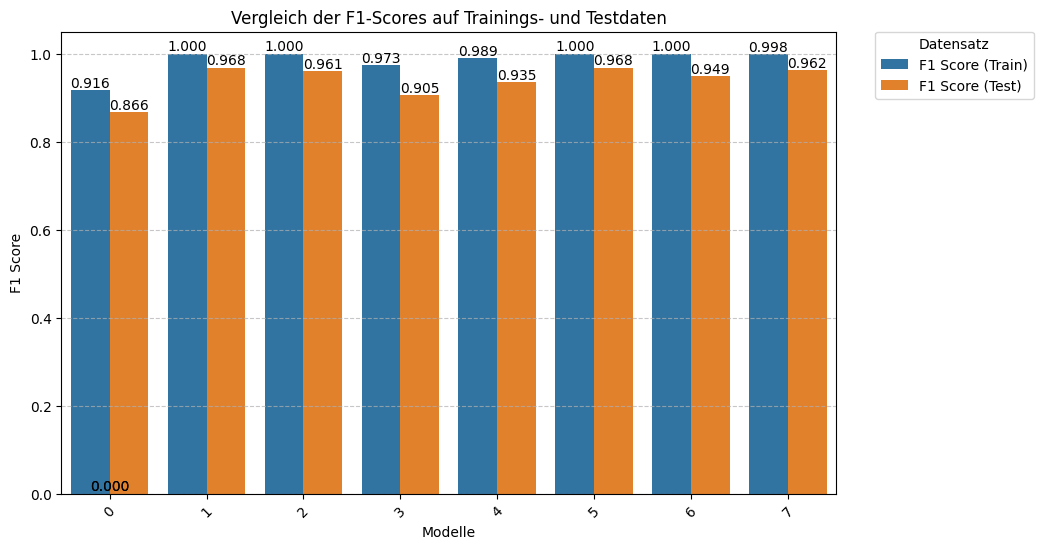

In [ ]:
# DataFrame für den Vergleich zwischen Train- und Test-F1-Scores erstellen
comparison_data = {
    "Model": results_df_test.index,
    "F1 Score (Train)": results_df_train["F1 Score"].values,
    "F1 Score (Test)": results_df_test["F1 Score"].values,
}

comparison_df = pd.DataFrame(comparison_data)

# Plot erstellen
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=comparison_df.melt(id_vars=["Model"], var_name="Dataset", value_name="F1 Score"),
    x="Model", y="F1 Score", hue="Dataset", palette=["#1f77b4", "#ff7f0e"]
)

# Achsentitel setzen
plt.xlabel("Modelle")
plt.ylabel("F1 Score")
plt.title("Vergleich der F1-Scores auf Trainings- und Testdaten")

# Werte über den Balken anzeigen
for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black')

# Legende außerhalb des Plots platzieren
plt.legend(title="Datensatz", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Plot anzeigen
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()